In [1]:
import pandas as pd

from transformers import DistilBertTokenizerFast
import nltk
import string
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter, defaultdict
from wordcloud import WordCloud
from gensim import corpora, models
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords') 

[nltk_data] Downloading package punkt to /Users/Merel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Merel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#load reddit posts
comments = pd.read_csv('/Users/Merel/Downloads/all_comments_since_2015 2.csv')

In [3]:
comments.shape

(17640062, 17)

In [4]:
#load author profiles
authorprofiles = pd.read_csv('/Users/Merel/Downloads/author_profiles 2.csv')

In [5]:
#merge the datasets
merged_df = pd.merge(comments, authorprofiles, on='author')

In [6]:
merged_df.shape

(17640061, 54)

In [7]:
english_count = (merged_df['lang'] == 'en').sum()
print("Number of entries with 'lang' as English:", english_count)

Number of entries with 'lang' as English: 16637210


In [8]:
#take only English reddit post
english_df = merged_df[merged_df['lang'] == 'en']

In [9]:
english_df.shape

(16637210, 54)

In [10]:
#remove NaNs
initial_length = len(english_df)

english_df.dropna(subset=[ 'agreeableness', 'openness', 'conscientiousness', 'extraversion',
       'neuroticism'], inplace=True)

entries_deleted = initial_length - len(english_df)

print(entries_deleted)

13806899


/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/434765885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df.dropna(subset=[ 'agreeableness', 'openness', 'conscientiousness', 'extraversion',


In [11]:
#remove bodies bigger than 100
def count_words(text):
    # Split the text by whitespace and count the number of words
    words = text.split()
    return len(words)


english_df['word_count'] = english_df['body'].apply(count_words)

# Filter out entries with more than 100 words
filtered_df = english_df[english_df['word_count'] <= 100]

# Count the number of deleted entries
deleted_entries = len(english_df) - len(filtered_df)

print(f"Deleted entries: {deleted_entries}")

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/3498540923.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['word_count'] = english_df['body'].apply(count_words)


Deleted entries: 248983


In [12]:
english_df.shape

(2830311, 54)

In [13]:
#Add only comments authors and big five traits in one df
# Create an empty DataFrame
commentbig5 = pd.DataFrame()

# Select specific columns from merged_df and assign them to commentbig5
commentbig5['author'] = english_df['author']
commentbig5['body'] = english_df['body']
commentbig5['agreeableness'] = english_df['agreeableness']
commentbig5['openness'] = english_df['openness']
commentbig5['conscientiousness'] = english_df['conscientiousness']
commentbig5['extraversion'] = english_df['extraversion']
commentbig5['neuroticism'] = english_df['neuroticism']

commentbig5.head()


,author,body,agreeableness,openness,conscientiousness,extraversion,neuroticism
0,MetricExpansion,Those stats come from the test. [Echoing the c...,30.0,70.0,15.0,15.0,50.0
1,MetricExpansion,"That's great to hear! I hope you know that, de...",30.0,70.0,15.0,15.0,50.0
2,MetricExpansion,I can totally agree on reticence! With respect...,30.0,70.0,15.0,15.0,50.0
3,MetricExpansion,I took it several times. I'm typed as TYPE_MEN...,30.0,70.0,15.0,15.0,50.0
4,MetricExpansion,Gawd it's like we don't even need drugs to be ...,30.0,70.0,15.0,15.0,50.0


In [14]:
#normalize
columns_to_rescale = ['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']
commentbig5[columns_to_rescale] = commentbig5[columns_to_rescale] / 100

In [15]:
commentbig5.head()

,author,body,agreeableness,openness,conscientiousness,extraversion,neuroticism
0,MetricExpansion,Those stats come from the test. [Echoing the c...,0.3,0.7,0.15,0.15,0.5
1,MetricExpansion,"That's great to hear! I hope you know that, de...",0.3,0.7,0.15,0.15,0.5
2,MetricExpansion,I can totally agree on reticence! With respect...,0.3,0.7,0.15,0.15,0.5
3,MetricExpansion,I took it several times. I'm typed as TYPE_MEN...,0.3,0.7,0.15,0.15,0.5
4,MetricExpansion,Gawd it's like we don't even need drugs to be ...,0.3,0.7,0.15,0.15,0.5


In [16]:
#look how often authors are in the df
author_counts = commentbig5['author'].value_counts()

author_counts_df = author_counts.reset_index()
author_counts_df.columns = ['author', 'count']
print(author_counts_df)


                 author  count
0         myexsparamour  52066
1     WittyOriginalName  44211
2         Silverlight42  43035
3          fifthchevron  41906
4            Shadow_Of_  33049
...                 ...    ...
1563    Erudite_Caveman      1
1564       elvesarecool      1
1565  quiapossevidentur      1
1566         FJackSteel      1
1567           mymy_316      1

[1568 rows x 2 columns]


In [17]:
#add the count to the dataframe
commentbig5 = pd.merge(commentbig5, author_counts_df, on='author', how='left')



KeyError: "['count_x', 'count_y'] not found in axis"

In [19]:
commentbig5.head()

,author,body,agreeableness,openness,conscientiousness,extraversion,neuroticism,count
0,MetricExpansion,Those stats come from the test. [Echoing the c...,0.3,0.7,0.15,0.15,0.5,2768
1,MetricExpansion,"That's great to hear! I hope you know that, de...",0.3,0.7,0.15,0.15,0.5,2768
2,MetricExpansion,I can totally agree on reticence! With respect...,0.3,0.7,0.15,0.15,0.5,2768
3,MetricExpansion,I took it several times. I'm typed as TYPE_MEN...,0.3,0.7,0.15,0.15,0.5,2768
4,MetricExpansion,Gawd it's like we don't even need drugs to be ...,0.3,0.7,0.15,0.15,0.5,2768


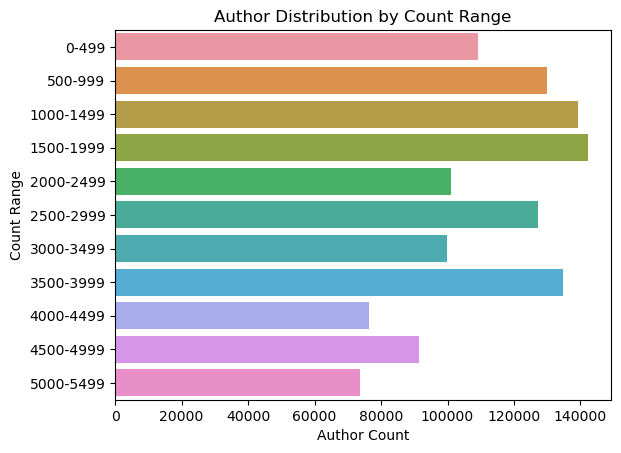

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' with columns 'authors' and 'count'

# Group the DataFrame by index and sum the 'count' for each index
author_counts = commentbig5.groupby(commentbig5.index)['count'].sum()

# Reset the index to convert the index to a regular column
author_counts = author_counts.reset_index()

# Define the bin edges and labels for the counts
bin_edges = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]  # Customize the bin edges as needed
bin_labels = ['0-499', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3499', '3500-3999', '4000-4499', '4500-4999', '5000-5499']  # Customize the bin labels as needed

# Bin the counts into ranges
author_counts['count_range'] = pd.cut(author_counts['count'], bins=bin_edges, labels=bin_labels)

# Count the number of authors in each range
count_range_counts = author_counts['count_range'].value_counts().reset_index().rename(columns={'index': 'Range', 'count_range': 'Author Count'})

# Create a bar plot using seaborn
sns.barplot(x='Author Count', y='Range', data=count_range_counts)

# Set labels and title
plt.xlabel('Author Count')
plt.ylabel('Count Range')
plt.title('Author Distribution by Count Range')

# Display the plot
plt.show()



In [34]:
#create sample
commentbig5['body'] = commentbig5['body'].astype(str)

# Get the unique authors from the dataset
unique_authors = commentbig5['author'].unique()

# Initialize an empty DataFrame for the new dataset
new_dataset = pd.DataFrame()

# Iterate over the unique authors
for author in unique_authors:
    # Filter the dataset for the current author
    author_cases = commentbig5[commentbig5['author'] == author].head(1)
    # Append the cases to the new dataset
    new_dataset = new_dataset.append(author_cases)
    # Break the loop if the new dataset exceeds 1000 lines
    if len(new_dataset) >= 2000:
        break

# Reset the index of the new dataset
new_dataset = new_dataset.reset_index(drop=True)

# Print the new dataset
print(new_dataset)

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

                author                                               body  \
0      MetricExpansion  Those stats come from the test. [Echoing the c...   
1             cyanisis  Ok ok op. Some other advice other than "just d...   
2          BadgerKid96  It does seem like it went pretty fast when I l...   
3        Silverlight42        ok who's using their force powers again...?   
4         pseudomuffin  Will recommend--works just as well as the name...   
...                ...                                                ...   
1563  TheAspiringTitan  Agreeableness: 11, Compassion: 25, Politeness:...   
1564     DanSoulKnight  Hey Everyone!Long time lurker here, and now I ...   
1565             -fwer  October 6, 2017 Resultsvia understandmyself.co...   
1566        lonely_ren  Extraversion - 6th percentile - extremely lowA...   
1567            khurtd  Welp, he ll allways be remebered as one of the...   

      agreeableness  openness  conscientiousness  extraversion  neuroticism

/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)
/var/folders/dd/22__xxxn57v1cd2_j_075d000000gq/T/ipykernel_24384/1724378178.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset = new_dataset.append(author_cases)


In [35]:
new_dataset.shape

(1568, 8)

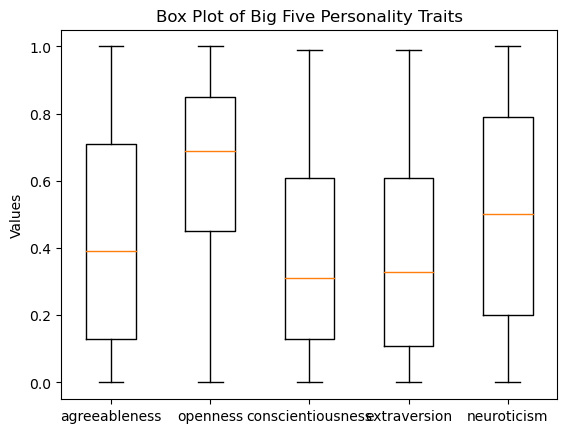

In [36]:
#boxplot cleaned data
# Specify the columns you want to plot
column1 = 'agreeableness'
column2 = 'openness'
column3 = 'conscientiousness'
column4 = 'extraversion'
column5 = 'neuroticism'

# Create a box plot for each column
plt.boxplot([commentbig5[column1],
             commentbig5[column2],
             commentbig5[column3],
             commentbig5[column4],
             commentbig5[column5]],
            positions=[1, 2, 3, 4, 5])

# Set the title and labels for the plot
plt.title('Box Plot of Big Five Personality Traits')
plt.xticks([1, 2, 3, 4, 5], [column1, column2, column3, column4, column5])
plt.ylabel('Values')

# Display the plot
plt.show()

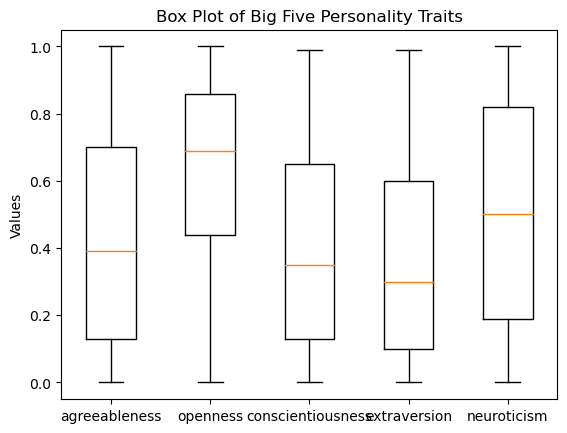

In [37]:
#boxplot sample
# Specify the columns you want to plot
column1 = 'agreeableness'
column2 = 'openness'
column3 = 'conscientiousness'
column4 = 'extraversion'
column5 = 'neuroticism'

# Create a box plot for each column
plt.boxplot([new_dataset[column1],
             new_dataset[column2],
             new_dataset[column3],
             new_dataset[column4],
             new_dataset[column5]],
            positions=[1, 2, 3, 4, 5])

# Set the title and labels for the plot
plt.title('Box Plot of Big Five Personality Traits')
plt.xticks([1, 2, 3, 4, 5], [column1, column2, column3, column4, column5])
plt.ylabel('Values')

# Display the plot
plt.show()

In [38]:
#NLTK's stopword list for English.
stop_words = stopwords.words('english')

new_dataset['body'] = new_dataset['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [39]:
# Define the tokenize function
def tokenize(text):
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    return text

# Apply the tokenize function to the 'body' column
new_dataset['body'] = new_dataset['body'].apply(tokenize)


In [40]:
new_dataset.to_csv('dfsmall.csv', index=False)